# Land Cover Classification
### Objective: Classify an image using the Scenes API and SciKit Learn

This image classification uses the Scenes API to filter the Landsat 8 Real Time Collection for relatively cloud free imagery above a small area in New Zealand. The tutorial uses GDAL to rasterize training data and scikit-learn to train and run a Random Forest Classification. We begin by importing the necessary libraries.

In [54]:
import descarteslabs as dl
from osgeo import gdal
# import os
import numpy as np
import scipy
from matplotlib import colors
from sklearn.ensemble import RandomForestClassifier 
from skimage.segmentation import quickshift, felzenszwalb
from skimage import exposure
from sklearn import metrics
import matplotlib.pyplot as plt
# %matplotlib inline

Lake Taupo is located on the North Island of New Zealand. The GeoJSON feature defined below is a rectangle containing the lake, mountains, and plantations. This feature will be used to search for imagery and as the extent of our analysis. 

In [2]:
lake_taupo = {
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          175.55877685546875,
          -39.27691581029594
        ],
        [
          176.319580078125,
          -39.27691581029594
        ],
        [
          176.319580078125,
          -38.638327308061875
        ],
        [
          175.55877685546875,
          -38.638327308061875
        ],
        [
          175.55877685546875,
          -39.27691581029594
        ]
      ]
    ]
  }
}

## Get data from Scenes API 

The Scenes API allows you to query our catalog of imagery. Here, we specify the geometry, product, and cloud fraction parameters to reflect our study's requirements. The `search` method returns a tuple containing the Scene Collection, and the GeospatialContext, where the first lists the image IDs and other metadata. The latter defines the spatial resolution, coordinate system, and other spatial parameters to apply to the Scenes. 

In [3]:
scenes, ctx = dl.scenes.search(lake_taupo['geometry'],
                    products=["landsat:LC08:01:RT:TOAR"],
                    start_datetime="2017-12-11",
                    end_datetime="2017-12-12",
                    cloud_fraction=0.7
                   )
ctx

AOI(geometry=<shapely.geom... 0x1c1eb4a160>,
    resolution=15,
    crs='EPSG:32660',
    align_pixels=True,
    bounds=(175.55877685546875, -39.27691581029594, 176.319580078125, -38.638327308061875),
    shape=None)

In [4]:
# You can modify the GeospatialContext as needed.
lowres_context = ctx.assign(resolution=60,crs='EPSG:32760')

In [6]:
arr = scenes[0].ndarray("red green blue", lowres_context)

A call to `ndarray` on one Scene from the Scene collection returns a masked array with the image's data.

In [7]:
# Set raster metadata for rasterizing our training data.
bands, rows, cols = arr.shape
geo_transform = [374566.1760405825, 60.0, 0.0, -4276862.181956149, 0.0, -60.0]
proj = 'PROJCS["WGS 84 / UTM zone 60N", GEOGCS["WGS 84", DATUM["WGS_1984", SPHEROID["WGS 84",6378137,298.257223563, AUTHORITY["EPSG","7030"]], AUTHORITY["EPSG","6326"]], PRIMEM["Greenwich",0, AUTHORITY["EPSG","8901"]], UNIT["degree",0.0174532925199433, AUTHORITY["EPSG","9122"]], AUTHORITY["EPSG","4326"]], PROJECTION["Transverse_Mercator"], PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",177],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0], UNIT["metre",1, AUTHORITY["EPSG","9001"]], AXIS["Easting",EAST], AXIS["Northing",NORTH], AUTHORITY["EPSG","32660"]]'

In [8]:
# Stack the bands of the data to prepare for classification
stacked = np.dstack((arr[0],arr[1],arr[2]))

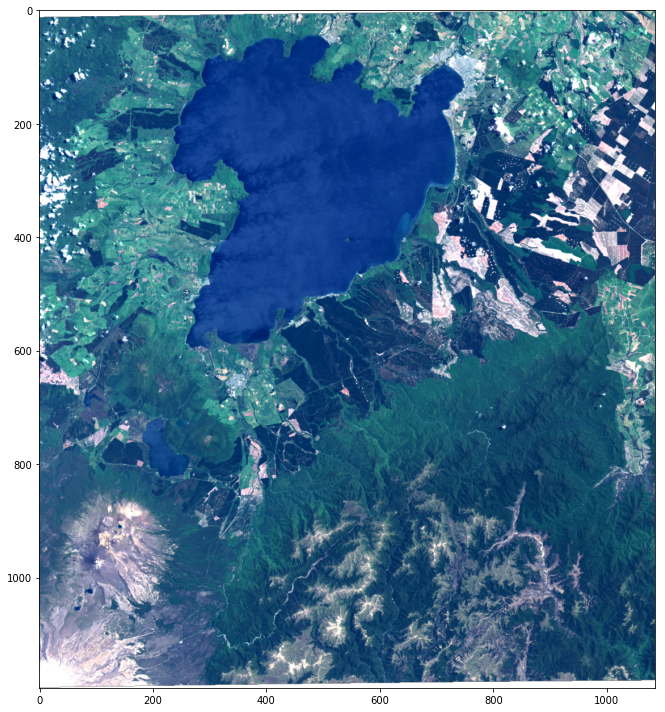

In [9]:
# Display the image data
dl.scenes.display(arr, size=10)

## Write helper functions to rasterize vector 
We need a library of functions to rasterize our training data.

In [10]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    print
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

## Segmentation

In [11]:
segments_quick = quickshift(stacked, kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print(n_segments)

46290


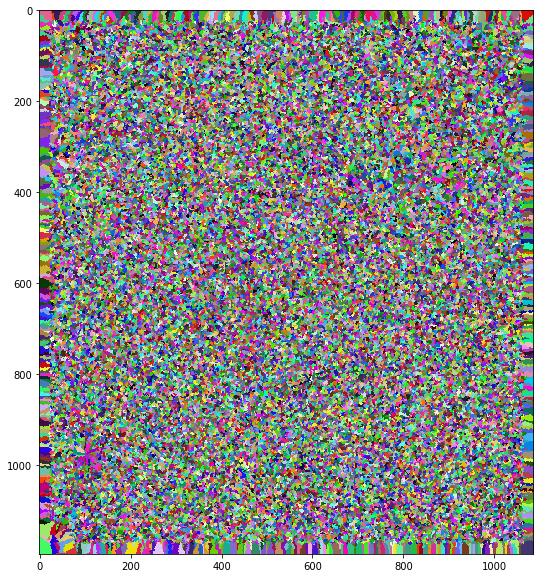

In [12]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
plt.figure(figsize=[10,10])
plt.imshow(segments_quick, interpolation='none', cmap=cmap)

In [13]:
rows, cols, n_bands = stacked.shape
band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(stacked[:, :, i], scale=85, sigma=0.25, min_size=9))

In [14]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(stacked.shape[:2])

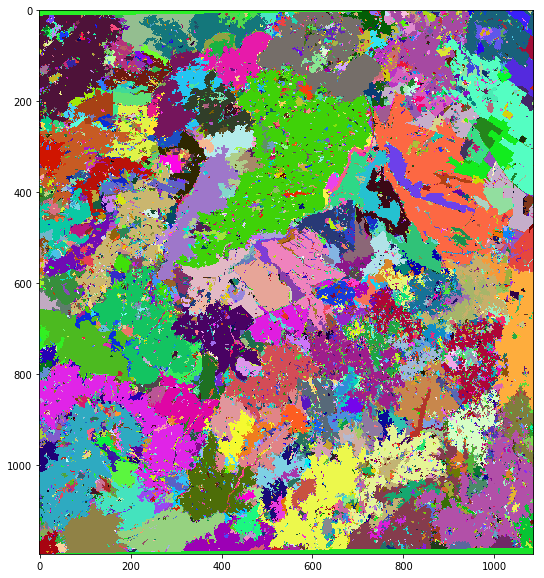

In [15]:
cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure(figsize=[10,10])
plt.imshow(segments_felz, interpolation='none', cmap=cmap)

In [ ]:
# DO NOT RUN 
n_segments = max(len(np.unique(s)) for s in [segments_quick, segments_felz])
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
#SHOW_IMAGES:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(stacked, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(segments_quick, interpolation='none', cmap=cmap)
ax2.set_title('Quickshift segmentations')
ax3.imshow(segments_felz, interpolation='none', cmap=cmap)
ax3.set_title('Felzenszwalb segmentations')
plt.show()

In [16]:
# We choose the quick segmentation
segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

Felzenszwalb segmentation. 12803 segments.


## Load training data

The data used to train the classifier are individual shapefiles being read in from a file. 

In [17]:
train_data_path = "data/train/"

In [18]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
class_labels = [f.split('.')[0] for f in files]
print("There are {} classes:".format(len(class_labels)))
for c in class_labels:
    print(c)
 
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = stacked[is_train]

There are 5 classes:
clear_cut
urban
mature_plantation
other
water


In [20]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
classes = np.unique(labeled_pixels)[1:]  # 0 doesn't count
len(classes)

In [22]:
segments_per_klass  = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 1: 13
Training segments for class 2: 2
Training segments for class 3: 18
Training segments for class 4: 20
Training segments for class 5: 16


## Classification

Train the classifier and run the land cover classification.

In [23]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

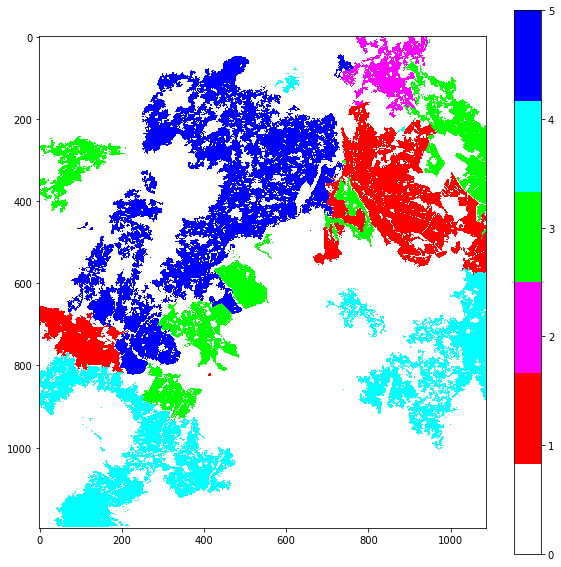

In [25]:
plt.figure(figsize=[10,10])
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

In [26]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

In [28]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU 
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = stacked[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

Created 12803 objects


In [29]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

Training samples for class 1: 13
Training samples for class 2: 2
Training samples for class 3: 18
Training samples for class 4: 20
Training samples for class 5: 16


In [31]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_objects, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
predicted  = classifier.predict(objects)
clf = np.copy(segments)
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

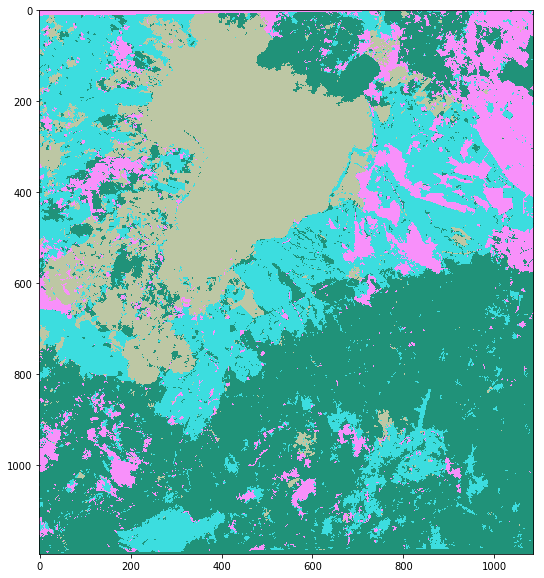

In [49]:
plt.figure(figsize=[10,10])
plt.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(class_labels), 3)))

## Classification validation

In [51]:
test_data_path = "data/test/"
shapefiles = [os.path.join(test_data_path, "%s.shp"%c) for c in class_labels]
verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
for_verification = np.nonzero(verification_pixels)

In [52]:
verification_labels = verification_pixels[for_verification]
predicted_labels = clf[for_verification]

In [55]:
cm = metrics.confusion_matrix(verification_labels, predicted_labels)

In [56]:
def print_cm(cm, labels):
    """pretty print for confusion matrixes"""
    # https://gist.github.com/ClementC/acf8d5f21fd91c674808
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

In [58]:
print_cm(cm, class_labels)

                 	        clear_cut	            urban	mature_plantation	            other	            water	
        clear_cut	                9	                0	                4	                2	                0	
            urban	                0	                0	                0	                2	                1	
mature_plantation	                4	                0	               15	                0	                0	
            other	                1	                0	                2	                8	                1	
            water	                0	                0	                0	                1	               18	


In [60]:
print("Classification accuracy: {}".format(metrics.accuracy_score(verification_labels, predicted_labels)))

Classification accuracy: 0.7352941176470589
